# Car Sales Analysis
The purpose of this document is to provide exploratory analysis of car sales data ranging from December 2014 to July 2015. Our team asks questions related to geographical location, make, model, and vehicle type.

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import requests
from pprint import pprint
import random
import json
import scipy.stats as stats
import hvplot.pandas

# Import the API key
from config import car_key
from config import car_secret_key


In [5]:
path = Path('Resources/car_sales_clean.csv')
cars_clean_df = pd.read_csv(path, encoding="utf-8")


In [6]:
path = Path('Resources/type_price_data.csv')
type_price_data_df = pd.read_csv(path, encoding="utf-8")

In [7]:
path = Path('Resources/stats_by_type.csv')
stats_by_type = pd.read_csv(path, encoding="utf-8")


In [8]:
path = Path('Resources/sorted_by_date.csv')
car_sales_sorted = pd.read_csv(path, encoding='utf-8')

In [9]:
path = Path('Resources/coordinates_df.csv')
coordinates_df = pd.read_csv(path, encoding='utf-8')

In [14]:
path = Path('Resources/monthly_model_sales.csv')
monthly_model_sales = pd.read_csv(path, encoding="utf-8")

# How do car sales vary by region?

In [8]:
# Wisdom's map here
us_plot = coordinates_df.hvplot.points(
    "longitude",
    "latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 1200,
    frame_height = 800,
    size = "Sales",
    scale = 0.2,
    color = "State",
    hover_cols = ["State","Sales","Average Selling Price"]
)
us_plot

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [longitude,latitude]   (State,Sales,Average Selling Price)

# Are there any correlations between type, features and sales performance? 
### Vehicle types can be defined as convertible, coupe, hatchback, minivan, SUV, sedan, truck, van and wagon. Features include aspects like colors and odometer. These varibles must have an impact on vehicle price and our goal is to uncover what kind of impact they have.

### Type price distributions
#### The following boxplots represent the distribution of prices for each vehicle type. The first has outliers included and the second has the outliers hidden and means shown.
Convertibles and coupes have many outliers, with a distribution that is skewed right. This is supported by the second boxplot for convertibles and coupes, as both means are higher than the medians. Means are less resistant to outlying data. Though hatchbacks and sedans both have outliers, these distributions appear to be the most normally distributed. This may be due to a smaller range in prices. Looking at the second boxplot for these types reveals means that are very close to the medians. The remaining types all show longer upper tails than lower tails, with means and medians approximately the same except for vans. The boxplot for vans shows a median that is higher than its mean.

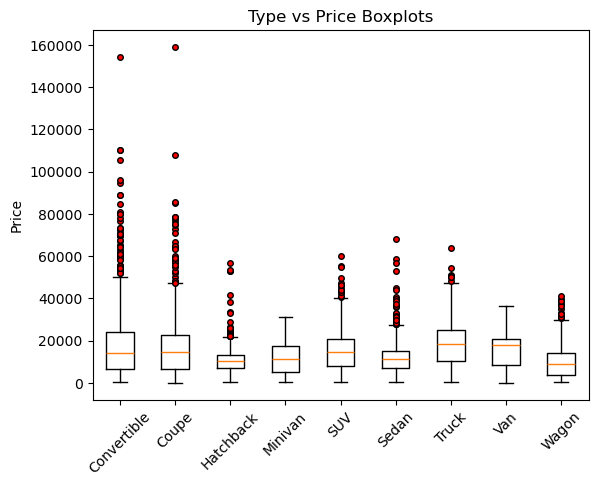

In [9]:
types = stats_by_type['type'].tolist()

plt.boxplot(type_price_data_df, labels=types, flierprops={'markersize': 4, 'markerfacecolor': 'red'})
plt.xticks(rotation=45)
plt.ylabel('Price')
plt.title('Type vs Price Boxplots')
plt.savefig('Output/typeVsPriceBoxplots.png')
plt.show()

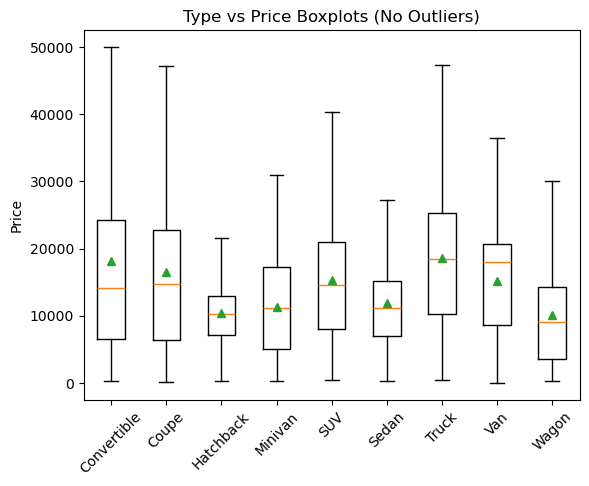

In [10]:
plt.boxplot(type_price_data_df, labels=types, showfliers=False, showmeans=True)
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.title('Type vs Price Boxplots (No Outliers)')
plt.savefig('Output/typeVsPriceSansOutliers.png')
plt.show()

In [11]:
group_types_clean = car_sales_sorted.groupby('type')

type_dataframes_clean = {type: group for type, group in group_types_clean}

conv_dict = {'Convertible': type_dataframes_clean['Convertible'].groupby(['saleyear', 'month'])['year'].count().reset_index()}
coupe_dict = {'Coupe': type_dataframes_clean['Coupe'].groupby(['saleyear', 'month'])['year'].count().reset_index()}
minivan_dict = {'Minivan': type_dataframes_clean['Minivan'].groupby(['saleyear', 'month'])['year'].count().reset_index()}
suv_dict = {'SUV': type_dataframes_clean['SUV'].groupby(['saleyear', 'month'])['year'].count().reset_index()}
sedan_dict = {'Sedan': type_dataframes_clean['Sedan'].groupby(['saleyear', 'month'])['year'].count().reset_index()}
truck_dict = {'Truck': type_dataframes_clean['Truck'].groupby(['saleyear', 'month'])['year'].count().reset_index()}
van_dict = {'Van': type_dataframes_clean['Van'].groupby(['saleyear', 'month'])['year'].count().reset_index()}
wagon_dict = {'Wagon': type_dataframes_clean['Wagon'].groupby(['saleyear', 'month'])['year'].count().reset_index()}

type_dict_list = [conv_dict, coupe_dict, minivan_dict, suv_dict, sedan_dict, truck_dict, van_dict, wagon_dict]


### Type price data over time
#### The following line chart represents the change of price in vehicle type for every month present in the data set. The sales data was only available from Dec 2014 to July 2015, with a gap in April. Despite these limitations of the data, meaningful information about vehicles can be derived.
Each vehicle type has relatively consistent sales over time, with sedans selling the most overall and vans selling the least. The month with the most sales overall is February, with sedan sales just under 70000. There is a massive decrease in sales from February to April, but this is most likely due to an issue with the data set. The largest increase in sales is from January to February.

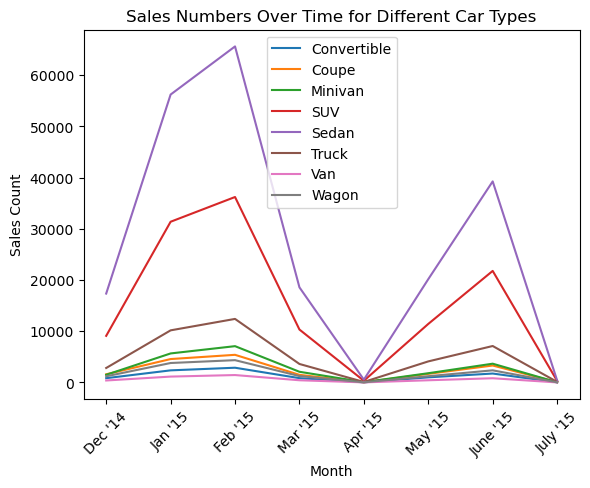

In [12]:
x_axis_dates = ["Dec '14", "Jan '15", "Feb '15", "Mar '15", "Apr '15", "May '15", "June '15", "July '15"]

fig, ax = plt.subplots()
x_axis =  np.arange(8)
tick_locations = [value for value in x_axis]

# Iterate over unique car types and plot sales count over time
for dictionary in type_dict_list:
    for name, type in dictionary.items():
        ax.plot(type.index, type['year'], label = name)

# Add labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Sales Count')
ax.set_title('Sales Numbers Over Time for Different Car Types')
plt.xticks(tick_locations, x_axis_dates, rotation=45)
ax.legend()

# Display the plot
plt.savefig('Output/typeSalesOverTime.png')
plt.show()

# How do top selling car models trend over time? Does an increase in sales indicate changes in price (or other factors)?

In [14]:
# search base URL
base_url = f"https://mc-api.marketcheck.com/v2/popular/cars?api_key={car_key}&car_type=new&country=us"


response = requests.get(base_url).json()



<Figure size 1000x600 with 0 Axes>

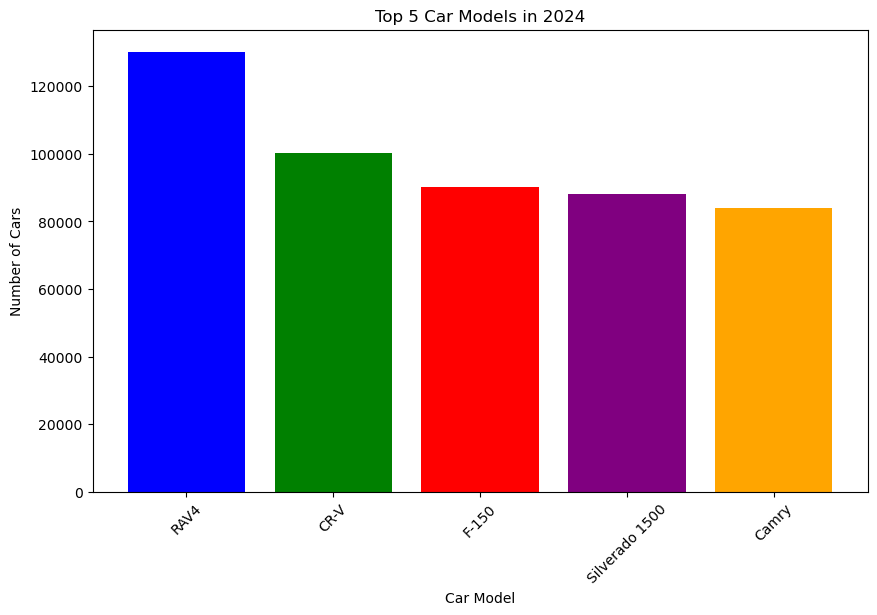

In [15]:
colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow', 'cyan', 'magenta', 'brown', 'pink']

top50_df = pd.DataFrame(response)
top50_df
df_expanded = pd.concat([top50_df.drop(['price_stats'], axis=1), top50_df['price_stats'].apply(pd.Series)], axis=1)
df_expanded = df_expanded.drop("miles_stats", axis=1)
df_expanded = df_expanded.drop("dom_stats", axis=1)
df_expanded
plt.figure(figsize=(10, 6))  # Set the figure size
top_5_cars = df_expanded.head(5)  # Select the top 5 cars

plt.figure(figsize=(10, 6))  # Set the figure size

plt.bar(top_5_cars['model'], top_5_cars['count'], color = colors)  # Create the bar chart for the top 5 cars

plt.xlabel('Car Model')  # Set the x-axis label
plt.ylabel('Number of Cars')  # Set the y-axis label
plt.title('Top 5 Car Models in 2024')  # Set the title

plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.savefig('Output/topFive2024.png')
plt.show()  # Display the plot

TOp 5 Cars Sold from Dec 2014 to Jul 2015



<!-- Accord:
Best Month: February 2015 with 2,459 units sold.
Worst Month: July 2015, where sales dropped to just 14 units.
Trend: The Accord saw a significant spike in February but experienced a steep drop by April. Sales picked up again in June but fell off once more in July. This suggests that sales can vary widely, possibly due to seasonal factors or changes in marketing.

Altima:
Best Month: February 2015, with a high of 5,348 units sold.
Worst Month: July 2015, with just 21 units sold.
Trend: The Altima also peaked in February and saw a big dip by July. Sales were consistently strong except for July, indicating that the model was quite popular for most of the period.

Camry:
Best Month: February 2015, with 2,983 units sold.
Worst Month: July 2015, with only 10 units sold.
Trend: Similar to the other models, the Camry’s sales peaked in February and dropped significantly by July. The Camry generally had high sales, although it experienced some fluctuations.

Civic:
Best Month: January 2015, with 2,089 units sold.
Worst Month: April 2015, with just 16 units sold.
Trend: The Civic saw its highest sales in January and its lowest in April. There was a noticeable recovery in sales in the following months, suggesting that it could be influenced by seasonal trends or market adjustments.

F-150:
Best Month: February 2015, with 3,725 units sold.
Worst Month: April 2015, with only 29 units sold.
Trend: The F-150’s sales also peaked in February but fell sharply by April. The model had strong sales early in the year but declined significantly in the middle of the year. -->

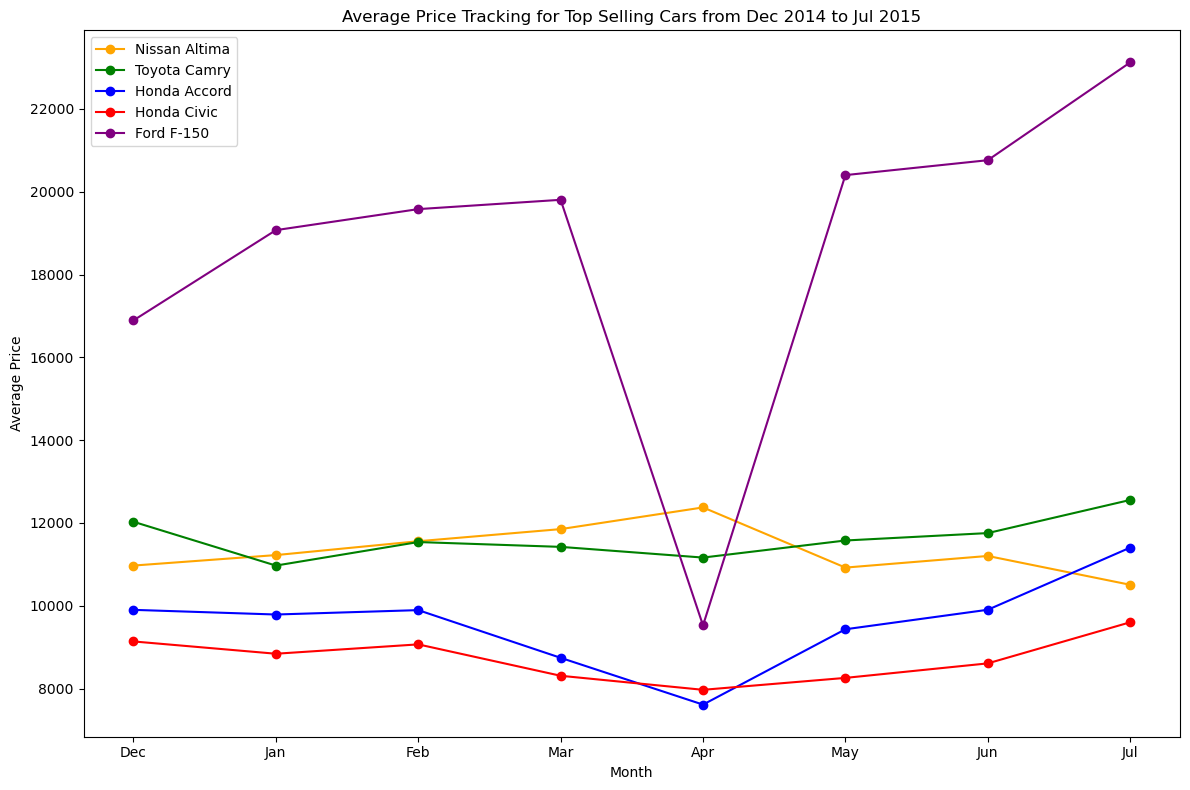

In [18]:
#Splitting date sold by its components of Date, Month and Year
cars_clean_df['saledate'] = cars_clean_df['saledate'].astype(str)
cars_clean_df['month'] = cars_clean_df['saledate'].str.split().str[1]
cars_clean_df['salesyear'] = cars_clean_df['saledate'].str.split().str[3]
cars_clean_df['day'] = cars_clean_df['saledate'].str.split().str[2]
# Define the custom order for months
custom_order = ['Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul']
colors = ['orange', 'green', 'blue', 'red', 'purple']
# Get the first month's top selling cars
first_month = custom_order[0]
top_selling_cars_first_month = cars_clean_df[cars_clean_df['month'] == first_month].groupby(['make', 'model']).size().reset_index(name='number_sold')
top_selling_cars_first_month = top_selling_cars_first_month.sort_values(by='number_sold', ascending=False).head(5)
tracked_cars = top_selling_cars_first_month[['make', 'model']].values

# Create a line plot for all tracked cars in one graph
plt.figure(figsize=(12, 8))

for i, (make, model) in enumerate(tracked_cars):
    car_data = []  # Store average price data for the car
    for month in custom_order:
        car_month_data = cars_clean_df[(cars_clean_df['month'] == month) & 
                                       (cars_clean_df['make'] == make) & 
                                       (cars_clean_df['model'] == model)]
        avg_price = car_month_data['sellingprice'].mean()
        car_data.append(avg_price)

    plt.plot(custom_order, car_data, marker='o', label=f'{make} {model}', color = colors[i])

plt.xlabel('Month')
plt.ylabel('Average Price')
plt.title('Average Price Tracking for Top Selling Cars from Dec 2014 to Jul 2015')
plt.legend()
plt.tight_layout()

# Save the figure as a PNG file
plt.savefig('Output/all_tracked_cars_avg_price_tracking.png')

plt.show()

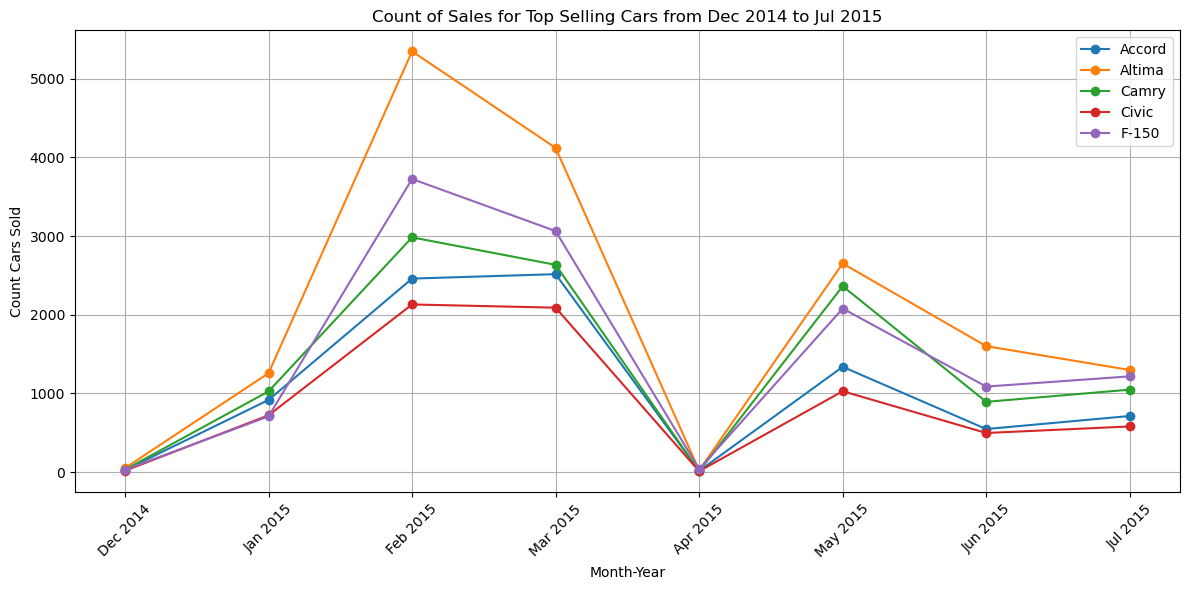

In [17]:

plt.figure(figsize=(12, 6))

# Plot a line graph for each model
for model in monthly_model_sales.columns:
    plt.plot(monthly_model_sales.index, monthly_model_sales[model], marker='o', label=model)

# Customize x-axis labels
custom_labels = ['Dec 2014', 'Jan 2015', 'Feb 2015', 'Mar 2015', 'Apr 2015', 'May 2015', 'Jun 2015', 'Jul 2015']
plt.xticks(monthly_model_sales.index, custom_labels, rotation=45)

plt.xlabel('Month-Year')
plt.ylabel('Count Cars Sold')
plt.title('Count of Sales for Top Selling Cars from Dec 2014 to Jul 2015')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

Key Takeaways
Peak Performance: February was a standout month for all models, likely due to seasonal promotions or market dynamics.
Summer Slump: Sales generally dropped in July across all models, which could point to a summer slowdown or reduced promotional activity.
Sales Variability: There’s a lot of fluctuation in sales, suggesting that various factors such as promotions, new model releases, or market conditions can significantly impact sales performance.
Overall, these trends highlight how car sales can vary over time and suggest that external factors might play a big role in these fluctuations.

Key Observations:

Cross-Analysis of Sales and Prices
February Peak: In February 2015, the Nissan Altima achieved its highest sales (5,348 units) with an average price of $12,180.03. This indicates strong sales performance even with a relatively high price.
April Decline: In contrast, April 2015 saw a steep drop in sales to just 50 units, despite the highest average price of $14,613.64. This suggests that the price increase may have been too significant, leading to reduced sales.

General Trends:
Price Sensitivity: The data shows that substantial price increases can lead to decreased sales, highlighting a sensitivity to price changes.
Seasonal and Market Factors: Sales peaks, such as in February, may be influenced by seasonal promotions or market dynamics, whereas declines, such as in April, could reflect seasonal slowdowns or inventory problems.

Conclusion
Sales Trends: Sales figures for top-selling car models vary notably over time, often reflecting pricing changes and other external factors.
Price Impact: Significant price increases are often associated with lower sales, as evidenced by the Nissan Altima's performance in April 2015.
External Influences: Sales trends are influenced by a combination of price adjustments, seasonal factors, and market conditions, making it crucial to consider all these elements in sales analysis.

Limitations: 
Short Duration: The data covers a relatively short period (from December 2014 to July 2015). This limited timeframe may not capture longer-term trends, seasonal variations beyond a year, or broader market shifts.
Potential Data Gaps: There may be inconsistencies or missing data points that could affect the analysis. For instance, the drastic drop in April 2015 sales might be due to data entry errors or other anomalies.
Lack of Comprehensive Pricing Information: The sale prices are only reflective a few months, and it might not consider promotional discounts, regional price variations, or changes in features that could impact prices.